In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 定义 Masked Autoencoder 模型
class MaskedAutoencoder(nn.Module):
    def __init__(self):

        super(MaskedAutoencoder, self).__init__()
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),  # 输出像素值在 [0, 1] 范围内
        )

    def forward(self, x, mask):
        # 掩码输入数据
        masked_x = x * mask
        # 编码器提取潜在表示
        latent = self.encoder(masked_x.view(masked_x.size(0), -1))  # 展平输入
        # 解码器重建完整数据
        recon_x = self.decoder(latent).view(x.size())  # 恢复原始形状
        return recon_x

# 训练函数
def train(model, dataloader, optimizer, device):
    model.train()
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)
        # 随机生成掩码
        mask = torch.bernoulli(torch.ones_like(x) * 0.5).to(device)
        # 模型重建
        recon_x = model(x, mask)
        # 计算损失（仅对被掩码的部分计算）
        loss = F.mse_loss(recon_x * (1 - mask), x * (1 - mask))
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

# 预测并可视化结果
def predict_and_visualize(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        # 获取一个测试批次
        test_data, _ = next(iter(test_loader))
        test_data = test_data.to(device)
        # 生成掩码
        mask = torch.bernoulli(torch.ones_like(test_data) * 0.5).to(device)
        # 重建图像
        recon_data = model(test_data, mask)
        # 可视化原始图像、掩码图像和重建图像
        plt.figure(figsize=(10, 6))
        for i in range(5):
            plt.subplot(3, 5, i + 1)
            plt.imshow(test_data[i].squeeze().cpu(), cmap="gray")
            plt.title("Original")
            plt.axis("off")
            plt.subplot(3, 5, i + 6)
            plt.imshow((test_data[i] * mask[i]).squeeze().cpu(), cmap="gray")
            plt.title("Masked")
            plt.axis("off")
            plt.subplot(3, 5, i + 11)
            plt.imshow(recon_data[i].squeeze().cpu(), cmap="gray")
            plt.title("Reconstructed")
            plt.axis("off")
        plt.show()

In [ ]:
# 主函数
def main():
    # 设置设备（GPU 或 CPU）
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 数据预处理
    transform = transforms.Compose([
        transforms.ToTensor(),  # 将图像转换为张量，并归一化到 [0, 1]
    ])
    # 加载 MNIST 数据集
    train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
    
    # 初始化模型
    model = MaskedAutoencoder().to(device)
    # 初始化优化器
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    # 训练模型
    for epoch in range(1, 11):
        print(f"Epoch {epoch}")
        train(model, train_loader, optimizer, device)
    
    # 预测并可视化结果
    predict_and_visualize(model, test_loader, device)


In [12]:
from torch.nn import functional as F

Epoch 1
Batch 0, Loss: 0.11504233628511429
Batch 100, Loss: 0.03432590141892433
Batch 200, Loss: 0.03035047836601734
Batch 300, Loss: 0.02752659283578396
Batch 400, Loss: 0.022161731496453285
Batch 500, Loss: 0.01924734003841877
Batch 600, Loss: 0.017385045066475868
Batch 700, Loss: 0.016758304089307785
Batch 800, Loss: 0.016971731558442116
Batch 900, Loss: 0.015614514239132404
Epoch 2
Batch 0, Loss: 0.0154721699655056
Batch 100, Loss: 0.015500068664550781
Batch 200, Loss: 0.013706741854548454
Batch 300, Loss: 0.015178750269114971
Batch 400, Loss: 0.015337090007960796
Batch 500, Loss: 0.014853258617222309
Batch 600, Loss: 0.012507820501923561
Batch 700, Loss: 0.014017496258020401
Batch 800, Loss: 0.01324007473886013
Batch 900, Loss: 0.012941209599375725
Epoch 3
Batch 0, Loss: 0.012718446552753448
Batch 100, Loss: 0.012408186681568623
Batch 200, Loss: 0.01138350646942854
Batch 300, Loss: 0.01250614132732153
Batch 400, Loss: 0.012010698206722736
Batch 500, Loss: 0.013194923289120197
Batc

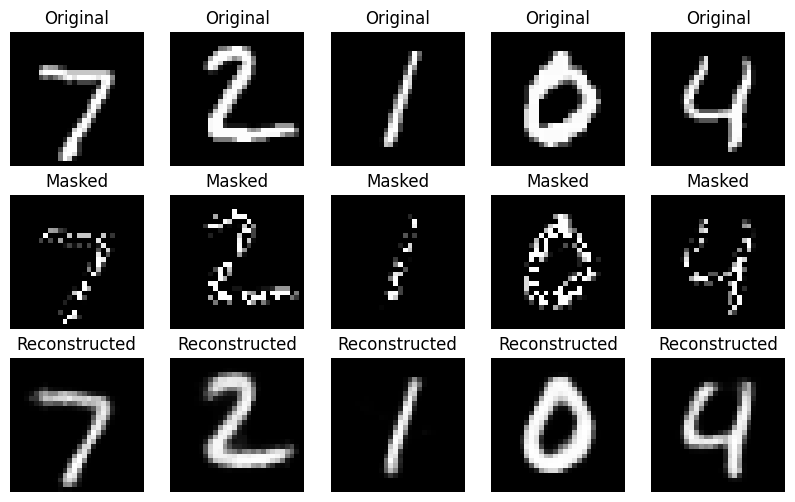

In [13]:
# 程序入口
if __name__ == "__main__":
    main()
